<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-the-data" data-toc-modified-id="Loading-the-data-1">Loading the data</a></span></li><li><span><a href="#Imputation-of-missing-values" data-toc-modified-id="Imputation-of-missing-values-2">Imputation of missing values</a></span></li><li><span><a href="#Feature-construction-with-one-hot-encoding" data-toc-modified-id="Feature-construction-with-one-hot-encoding-3">Feature construction with one-hot encoding</a></span></li><li><span><a href="#Standardization-of-numerical-values" data-toc-modified-id="Standardization-of-numerical-values-4">Standardization of numerical values</a></span></li><li><span><a href="#Build-the-model" data-toc-modified-id="Build-the-model-5">Build the model</a></span><ul class="toc-item"><li><span><a href="#Univariate-Model" data-toc-modified-id="Univariate-Model-5.1">Univariate Model</a></span><ul class="toc-item"><li><span><a href="#Plotting-the-predictions" data-toc-modified-id="Plotting-the-predictions-5.1.1">Plotting the predictions</a></span></li><li><span><a href="#Hyperparameter-optimization" data-toc-modified-id="Hyperparameter-optimization-5.1.2">Hyperparameter optimization</a></span></li></ul></li><li><span><a href="#Multivariate-Model" data-toc-modified-id="Multivariate-Model-5.2">Multivariate Model</a></span></li></ul></li><li><span><a href="#Improving-the-model-with-K-fold-cross-validation" data-toc-modified-id="Improving-the-model-with-K-fold-cross-validation-6">Improving the model with K-fold cross-validation</a></span><ul class="toc-item"><li><span><a href="#Forward-selection-&amp;-backward-elimination" data-toc-modified-id="Forward-selection-&amp;-backward-elimination-6.1">Forward selection &amp; backward elimination</a></span></li><li><span><a href="#Elbow-detection-point" data-toc-modified-id="Elbow-detection-point-6.2">Elbow detection point</a></span></li></ul></li><li><span><a href="#Final-Results" data-toc-modified-id="Final-Results-7">Final Results</a></span></li></ul></div>

# Price prediction with k-nearest neighbors algorithm

In this study, we'll cover how to:
- load the data
- impute missing values
- encode categorical features
- standardize numerical values
- train a k-nearest neighbors model and plot the predictions
- tune the hyperparameters of an estimator
- evaluate a model using cross-validation and error minimization
- improve the model with custom feature selection
- find the elbow point of a curve


## Loading the data
The [UCI website](https://archive.ics.uci.edu/ml/datasets/automobile) provides everything you need to get started:
- Training features, consisting of three types of entities: a) the specification of an auto in terms of various characteristics; b) its assigned insurance risk rating; c) its normalized losses in use as compared to other cars. 
- Target Feature, *i. e.* the variable which we want to predict: the price of the car, ranging from 5118 to 45400.

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

In [2]:
#dataquest solution
#https://github.com/dataquestio/solutions/blob/master/Mission155Solutions.ipynb
#about the dataset
#https://archive.ics.uci.edu/ml/datasets/automobile
#https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.names
#download the dataset
#https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data

In [3]:
attributes=["symboling",
            "normalized_losses",
            "make",
            "fuel_type",
            "aspiration",
            "doors",
            "body_style",
            "drive_wheels",
            "engine_location",
            "wheel_base",
            "length",
            "width",
            "height",
            "curb_weight",
            "engine_type",
            "num_cylinders",
            "engine_size",
            "fuel_system",
            "bore",
            "stroke",
            "compression_ratio",
            "horsepower",
            "peak_rpm",
            "city_mpg",
            "highway_mpg",
            "price"]

In [4]:
cars = pd.read_csv('data/imports-85.data',
                   header=None,
                   names=attributes)

Let's take a quick look at the raw data.

In [5]:
def highlight_missing_value(val):
    """    
    return the css property `'background-color: orange'` for "?" value, white otherwise.
    """
    color = 'orange' if val=="?" else 'white'
    return 'background-color: %s' % color

In [6]:
cars.head().style.applymap(highlight_missing_value)

,symboling,normalized_losses,make,fuel_type,aspiration,doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,curb_weight,engine_type,num_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


The dataset contains categorical and numerical variables. We will need to take this into account when preprocessing the dataset thereafter. Since we plan to perform a *linear regression*, it's imperative to work with *numerical values* only. The dataset has also missing values we need to fix.

## Imputation of missing values

According to the [Data Set Description](https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.names), the missing values are denoted by an interrogation point on the following attributes:
- normalized losses (41 missing values)
- doors (2)
- bore (4)
- stroke (4)
- horsepower (2)
- peak-rpm (2)
- price (4)

Unfortunately, this causes this attributes have been cast to Pandas objects even when they contain continuous values.

So we will do the following:
1. Remove the normalized losses column, since this attribute contains 20% of missing values.
2. Impute the continuous missing values by <code>np.nan</code> values.
3. Change the data type to float.
4. Remove the 4 observations with an unknown price since this attribute is our target.
5. Replace the remaining missing values by the mean of the attribute.

In [7]:
def remove_attribute(attribute, df):
    """
    Remove column from a dataframe
    
    attribute (string): the column name to remove
    df (DataFrame): the data
    
    """
    
    df.drop(attribute,axis=1,inplace=True)
    

def clean_continuous_attributes(mv_str, cols_index, df):
    """
    Replace missing vaalues by np.nan value and change object columns to float data type
    
    mv_str (string): the string denoting the missing value
    cols_index (list of integers) : the columns index we want to clean
    df (DataFrame) : the data  
        
    """
   
    for idx, col in enumerate(df.columns):
        if idx in cols_index:
            df[col]=df[col].replace(mv_str, np.nan)
            df[col]=df[col].astype(np.float64)
    return df

def remove_rows(target, df):
    """
    Remove rows with np.nan values from a DataFrame and reset the index
    
    target (array-like of strings): the column name which we want to remove np.nan values  
    df (DataFrame) : the data  
        
    """
    df.dropna(subset=target,inplace=True)
    df.reset_index(inplace=True)
    df.drop("index",axis=1,inplace=True)
    

def impute_missing_values(cols_index, df):
    """
    Replace np.nan values by the mean of the attribute    
    
    cols_index (list of integers) : the columns index we want to replace np.nan values by the mean
    df (DataFrame) : the data  
        
    """
    for idx, col in enumerate(df.columns):
        if idx in cols_index:        
            m = df[col].mean()
            df[col] = df[col].fillna(m)    
    return df

In [8]:
remove_attribute("normalized_losses", cars)
missing_values_col_index=[17,18,20,21,24]
cars = clean_continuous_attributes("?", missing_values_col_index, cars)
remove_rows(["price"], cars)
cars = impute_missing_values(missing_values_col_index, cars)
cars.head()

,symboling,make,fuel_type,aspiration,doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,audi,gas,std,four,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,audi,gas,std,four,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [9]:
#safety check
assert cars.isnull().sum().sum()==0

In [10]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 25 columns):
symboling            201 non-null int64
make                 201 non-null object
fuel_type            201 non-null object
aspiration           201 non-null object
doors                201 non-null object
body_style           201 non-null object
drive_wheels         201 non-null object
engine_location      201 non-null object
wheel_base           201 non-null float64
length               201 non-null float64
width                201 non-null float64
height               201 non-null float64
curb_weight          201 non-null int64
engine_type          201 non-null object
num_cylinders        201 non-null object
engine_size          201 non-null int64
fuel_system          201 non-null object
bore                 201 non-null float64
stroke               201 non-null float64
compression_ratio    201 non-null float64
horsepower           201 non-null float64
peak_rpm             201 non-

## Feature construction with one-hot encoding
We need also to replace the two missing values for the doors column by "unknown" and then to one-hot encode  (*i.e.*, generate a column by category) the categorical columns (including the symboling attribute).
Categorical variables cannot be included in a linear model if not coded as integers first and we want to avoid categorical features to be treated as ordered values. Since the symboling feature has ordered integer values, we will also one-hot encode this numerical attribute.

In [11]:
from sklearn.preprocessing import OneHotEncoder

In [12]:
#replace the two missing values for the doors column by "unknown"
cars["doors"]=cars["doors"].replace("?", "unknown")

In [13]:
#replace symboling attribute ordered values by letters
symboling_dict = { 3:"G", 2:"F", 1:"E", 0:"D", -1:"C", -2:"B", -3:"A" }
cars["symboling"] = cars["symboling"].apply(lambda x: symboling_dict[x])

In [14]:
#select columns object
cars_object = cars.select_dtypes('object')
#one-hot encoding
enc=OneHotEncoder().fit(cars_object)
#pass to array
encoded = enc.transform(cars_object).toarray()
#create a dataframe with the binary features
one_hot_encoded_features = pd.DataFrame(index=cars.index)
#put binary features names in a readable fashion
binary_col_names = enc.get_feature_names(cars_object.columns)

for idx, feature in enumerate(binary_col_names):
    one_hot_encoded_features[feature]=encoded[:,idx]
one_hot_encoded_features.head()

,symboling_B,symboling_C,symboling_D,symboling_E,symboling_F,symboling_G,make_alfa-romero,make_audi,make_bmw,make_chevrolet,...,num_cylinders_twelve,num_cylinders_two,fuel_system_1bbl,fuel_system_2bbl,fuel_system_4bbl,fuel_system_idi,fuel_system_mfi,fuel_system_mpfi,fuel_system_spdi,fuel_system_spfi
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


The mean value of binary features shows us the prevalence, meaning what proportion of the described object has that characteristic.
The plot below shows that a dozen characteristics are common across cars, but most of them concern less than 20% of the dataset.

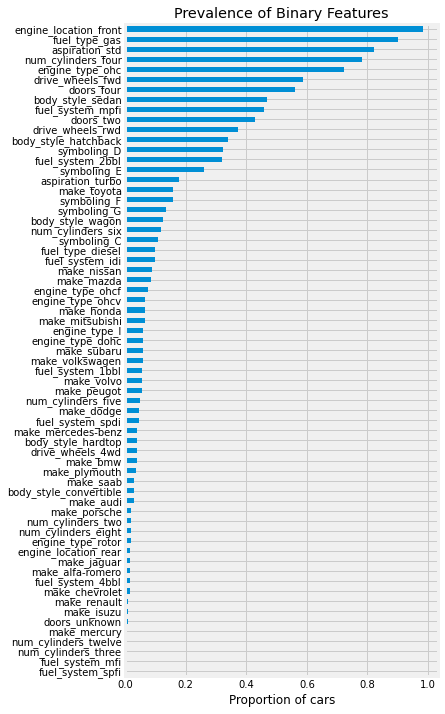

In [15]:
one_hot_encoded_features.apply(pd.value_counts)
sorted_one_hot_encoded_features = one_hot_encoded_features.iloc[:, 1:].mean().sort_values()
ax = sorted_one_hot_encoded_features.plot(kind='barh',
                                 stacked=True,
                                 figsize=(5, 12),
                                 title='Prevalence of Binary Features')
ax.set_xlabel('Proportion of cars');

## Standardization of numerical values

As mentioned by the [scikit-learn documentation](https://scikit-learn.org/stable/modules/preprocessing.html):
> If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

That's why we need to transform the data so that each attribute will be like standard normally distributed data (Gaussian) with zero mean and unit variance.

In [16]:
#remove all object features since we constructed binary features from them
cars=cars.drop(cars.select_dtypes('object').columns,axis=1)
#join binary features and continuous features
all_features = one_hot_encoded_features.join(cars)

In [17]:
#normalize the numerical values
standardized_cars = (all_features - all_features.mean())/(all_features.std())
#reintroduce the non normalized target column
standardized_cars["price"] = all_features["price"]
#safety check if mean = 0 and variance = 1 for each column
assert np.isclose(standardized_cars.std(),1.0).sum()==len(standardized_cars.columns)-1
assert np.isclose(standardized_cars.mean(),0).sum()==len(standardized_cars.columns)-1

Let’s get some insights by looking at the variables' distributions and at the pairwise relationships between them. Only main continuous variables will be used. The following plot shows their Pearson standard correlation coefficients.

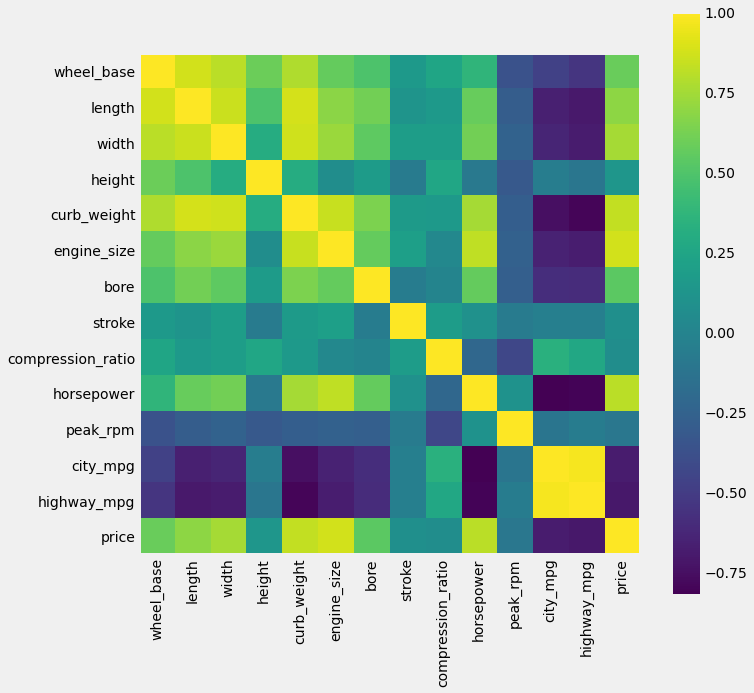

In [18]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,10))
continuous_idx = len(one_hot_encoded_features.columns)
ticks = range(len(standardized_cars.columns)-continuous_idx)
dt = standardized_cars.iloc[:,continuous_idx:]
plt.grid(False)
plt.imshow(dt.corr())
plt.xticks(ticks,dt.columns,rotation=90)
plt.yticks(ticks,dt.columns)
plt.colorbar()
plt.show()

We can see that some variables are strongly linearly correlated, exhibiting clusters (length, width, wheelbase, or between city-mpg and highway-mpg). Risk of redundancy here and that may decrease the performance of the model since correlated features are known to induce instabilities.
Regarding price target, the strongest correlation occurs with the engine size attribute, so we can expect this feature to be a good predictor.

## Build the model
Now we have removed the discrete variables, we are ready to perform a linear regression based on the k-nearest neighbors (KNN) algorithm using the root of mean squared error (RMSE) as error metric during test/train validation. First, we will fit a univariate model, useful to know which features are the best predictors.
### Univariate Model

In [19]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [20]:
def knn_train_test(col_names, target, df, k = 5):
    """
    Trains a KNN model and returns the RMSE
    
    col_names (string): the training features
    target (string): the column target
    df (DataFrame): the data
    k (int) : the number of neighbors
    
    output (float) : RMSE
    """
    #initiate a seed for reproductibility 
    np.random.seed(123)
    #randomization
    p = np.random.permutation(len(df))
    df = df.loc[p]
    #using 50/50 split for training and testing data
    l = len(df)//2
    #train only col_name
    train_feature = df.iloc[0:l][col_names]#.values.reshape(l,1)
    test_feature = df.iloc[l:][col_names]#.values.reshape(len(df)-l,1)
    #target
    train_target = df.iloc[0:l][target]
    test_target = df.iloc[l:][target]
    #instantiate KNeighborsRegressor class with default parameters
    knn = KNeighborsRegressor(n_neighbors = k)
    # Pass everything into the fit method.
    knn.fit(train_feature, train_target)
    #making predictions on the testing set using the training data 
    predictions = knn.predict(test_feature)
    #calculating mean squared error (MSE) and root mean squared error (RMSE)
    predictions_mse = mean_squared_error(test_target, predictions)
    predictions_rmse = predictions_mse ** (1/2)
    return predictions_rmse

In [21]:
target = "price"
rmse=[]
for col in standardized_cars.columns[:-1]:    
    rmse.append(knn_train_test([col], target, standardized_cars))
best_attributes = pd.Series(data=rmse, index=standardized_cars.columns[:-1]).sort_values()
best_attributes 

horsepower          4367.420884
engine_size         4622.893168
curb_weight         4741.616768
highway_mpg         5077.530212
city_mpg            5746.501341
                       ...     
fuel_system_spdi    9783.758088
make_plymouth       9787.573337
make_isuzu          9807.865944
make_mitsubishi     9808.004146
make_chevrolet      9918.293043
Length: 79, dtype: float64

#### Plotting the predictions
Since the car prices are ranging from 5118 to 45400, the best error score of 4367 seems pretty bad. Let's create a new function, namely <code>knn_predictions</code>, that will return the predictions and the testing set. Then we will plot the results with another function, <code>plot_pred</code>.

We also create another error score function returning the Mean Absolute Percentage Error (MAPE), fitting better with past results (Kibler *et al.*, 1989) for comparison purposes: 11,84% for their instance-based technique (IBL) algorithm derived from KNN algorithm, and 14,12 % for the resulting linear regression equation, according to [UCI website](https://archive.ics.uci.edu/ml/datasets/automobile).

In [22]:
def knn_predictions(col_names, target, df, k = 5):
    """
    Trains a KNN model, returns the predictions & testing set
    
    col_names (string): the training features
    target (string): the column target
    df (DataFrame): the data
    k (int) : the number of neighbors
    
    output: 
      test_target (Pandas series): the testing set
      predictions (array): model predictions
    
    """
    
    #initiate a seed for reproductibility 
    np.random.seed(123)
    #randomization
    p = np.random.permutation(len(df))
    df = df.loc[p]
    #using 50/50 split for training and testing data
    l = len(df)//2
    #train only col_name
    train_feature = df.iloc[0:l][col_names]#.values.reshape(l,1)
    test_feature = df.iloc[l:][col_names]#.values.reshape(len(df)-l,1)
    #target
    train_target = df.iloc[0:l][target]
    test_target = df.iloc[l:][target]
    #instantiate KNeighborsRegressor class with default parameters
    knn = KNeighborsRegressor(n_neighbors = k)
    # Pass everything into the fit method.
    knn.fit(train_feature, train_target)
    #making predictions on the testing set using the training data 
    predictions = knn.predict(test_feature)    
    return test_target, predictions

def mean_absolute_percentage_error(target, predictions):
    """
    Calculate MAPE error metric
    
    target (string): the attribute we want to predict
    predictions 
   
    output (float): MAPE score
    """    
    return np.mean(np.abs((target - predictions) / target))

def plot_pred(target, predictions, title=""):
    """
    Scatter plot of model predictions (y-axis) vs target (x-axis)
    
    target (1d array): the true values of the attribute we want to predict
    predictions (1d array): the predictions made by the model
    title (string, optional): the title of the chart
    
    """
    
    fig, ax = plt.subplots(figsize=(8, 8))
    mape = mean_absolute_percentage_error(target, predictions)
    string_score = f'MAPE on testing set: {mape:.2%}'
    ax.scatter(target, predictions)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes,ls="--", c="red")
    plt.text(10000, 27000, string_score)
    plt.title(title)
    plt.ylabel('Model predictions')
    plt.xlabel('Truths')
    plt.xlim(5000,46000)
    plt.ylim(5000,46000)
    plt.show()

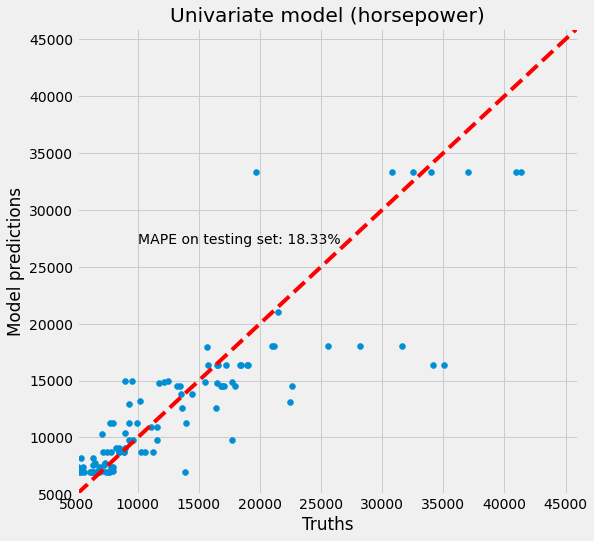

In [23]:
tt, pred = knn_predictions(["horsepower"], "price", standardized_cars)
plot_pred(tt, pred, "Univariate model (horsepower)")

The figure confirms our first intuition: the best univariate model is not very predictive. Good predictions should lie on the red line.
#### Hyperparameter optimization

Since the KNN algorithm is based on finding the $k$-neighbors of a data point, it may be possible to improve the model by tuning the $k$ parameter (namely <code>n_neighbors</code> parameter). As pointed in the [scikit-learn documentation](https://scikit-learn.org/stable/modules/neighbors.html#unsupervised-neighbors):
> The optimal choice of the [k] value is highly data-dependent: in general a larger suppresses the effects of noise, but makes the classification boundaries less distinct.

In other words, a smaller $k$ may lead to overfitting, while a larger value may come at the cost of predictive power (underfitting).

Shortcut:
- small $k$ value = low bias + high variance
- large $k$ value = high bias + low variance

So, this is about the famous [bias-variance tradeoff](http://scott.fortmann-roe.com/docs/BiasVariance.html). How to minimize bias without increasing variance, and *vice versa*?

In [24]:
#tuning k parameter and save the results into a DataFrame
univariate_model_df = pd.DataFrame(index=standardized_cars.columns[:-1])
for k in [1,3,5,7,9]:
    rmse=[]
    col_name="k"+str(k)
    for col in standardized_cars.columns[:-1]:       
        rmse.append(knn_train_test([col], target, standardized_cars, k))
    univariate_model_df[col_name]=rmse

In [25]:
#label the best RMSE scores by k-neighbors values
univariate_model_df.idxmin(axis=0)

k1    engine_size
k3    engine_size
k5     horsepower
k7    engine_size
k9    engine_size
dtype: object

Hyperparameter optimization doesn't look to upset dramatically the features importance, though the horsepower leadership is now challenged by the engine size attribute. Let's take a look.

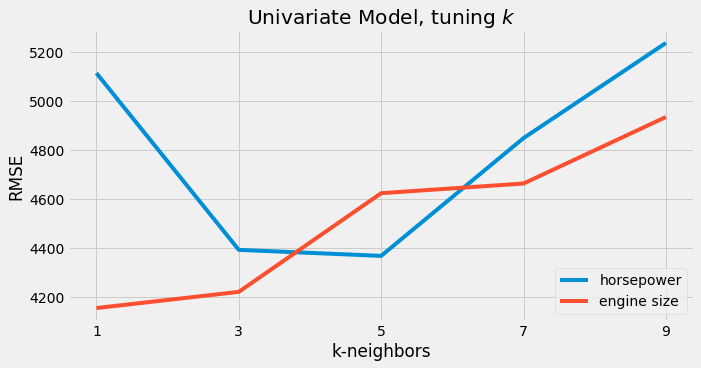

In [26]:
plt.figure(figsize=(10,5))
x=[1,3,5,7,9]
plt.plot(x,univariate_model_df.loc["horsepower"],label="horsepower")
plt.plot(x,univariate_model_df.loc["engine_size"],label="engine size")
plt.title("Univariate Model, tuning $k$")
plt.legend(loc='lower right')
plt.ylabel("RMSE")
plt.xlabel("k-neighbors")
plt.xticks(x)
plt.show()

Indeed, the univariate model based on the horsepower attribute didn't improve its initial error score of 4367 (with $k$ = 5, the default value). Remember that the engine size attribute has the best Pearson score (highly correlated to price variable). The figure confirms this fact since this attribute improves notably the univariate model by reaching the 4200 levels when $1\leq k \leq3$. But, as said before, low $k$ values present a non-negligible risk of overfitting, so it is preferable to be cautious with this result.

Let's now plot again the prediction and calculate the MAPE score.

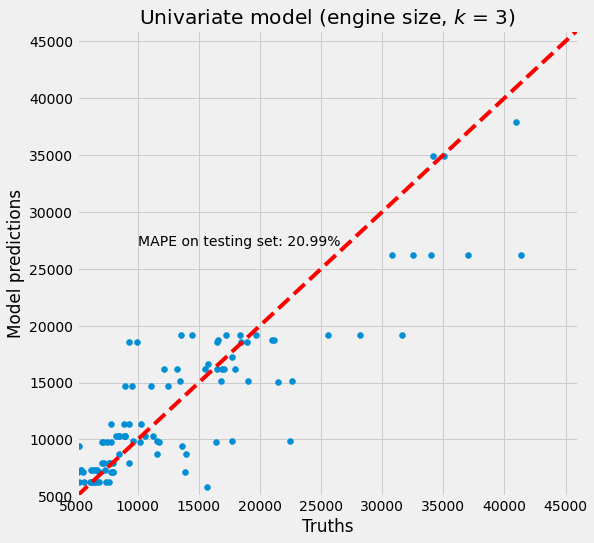

In [27]:
tt, pred = knn_predictions(["engine_size"], "price", standardized_cars, k = 3)
plot_pred(tt, pred, "Univariate model (engine size, $k$ = 3)") 

Surprisingly, the MAPE score is worst than expected! It means there is no linear relationship between RMSE and MAPE scores, at least for the engine size attribute. It's still unclear if the engine size attribute is more informative than the horsepower one.
Finally, despite hyperparameter optimization, the best univariate models are still poorly predictive.


### Multivariate Model
Since the univariate models are getting poor results, we will now build several multivariate models and work on feature selection.
Possible approaches consist of testing all attributes together or only the continuous ones.
However, by selecting the best attributes obtained during the hyperparameter optimization step (saved into <code>univariate_model_df</code> DataFrame), we can build several other multivariate models (with $k$ = 5, the default value) and save again the results.

In [28]:
#useful variable
total_features = len(standardized_cars.columns)-1

#full feature set model
target = "price"
full_feature_set = standardized_cars.columns[:-1].tolist()
print(knn_train_test(full_feature_set, target, standardized_cars))

5748.238867240251


In [29]:
#only continuous features
target = "price"
continuous_features = standardized_cars.iloc[:,66:-1].columns.tolist()
print(knn_train_test(continuous_features, target, standardized_cars))

4935.325727330618


At first glance, the binary features are not adding value to the model, at least when used indiscriminately. Indeed, the results above shows that the full feature set (*i.e.* absence of feature selection) has a larger score error than the model based on continuous features only. 

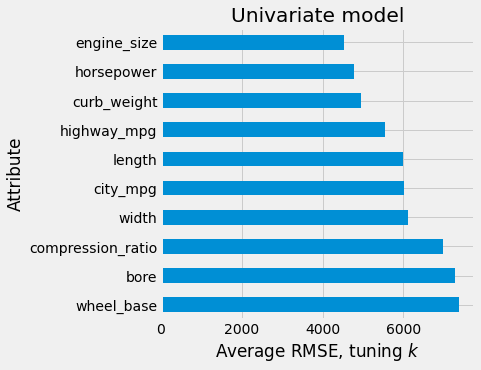

In [30]:
#print the top 10 obtained from previous hyperparameter optimization step
sorted_univariates = univariate_model_df.mean(axis=1).sort_values(ascending=False)
ax = sorted_univariates[-10:].plot(kind='barh',
                                 stacked=True,
                                 figsize=(5, 5),
                                 title='Univariate model')
ax.set_xlabel('Average RMSE, tuning $k$');
ax.set_ylabel('Attribute');

We will now build new models based on <code>univariate_model_df</code> sorted values, building feature sets to test by selecting the top-$X$ best features where $2\leq X \leq 77$ (total number of attributes).

In [31]:
#select the top-X index from univariate_model_df and build a model
rmse=[]
for i in range(2,total_features):
    col_names = univariate_model_df.mean(axis=1).sort_values().head(i).index
    rmse.append(knn_train_test(col_names, target, standardized_cars))

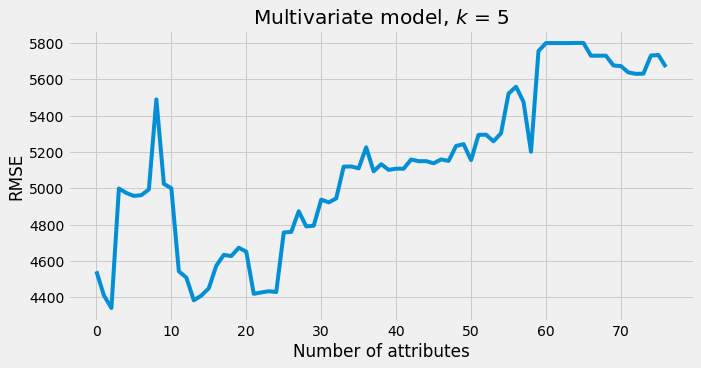

In [32]:
plt.figure(figsize=(10,5))
plt.plot(rmse)
plt.title("Multivariate model, $k$ = 5")
plt.xlabel("Number of attributes")
plt.ylabel("RMSE")
plt.show()

By using this hierarchical approach, we still don't see any significant improvement. The best univariate model (horsepower with default values) is still leading the competition in terms of RMSE (4367).
As for the univariate models, we will now tune the $k$ parameter and save the results into a DataFrame.

In [33]:
#tuning k parameter and save the results into a DataFrame
multivariate_model_df = pd.DataFrame(index=range(2,total_features))
for k in range(1,20):
    rmse=[]
    col_name="k"+str(k)
    for i in range(2,total_features):
        col_names = univariate_model_df.mean(axis=1).sort_values().head(i).index  
        rmse.append(knn_train_test(col_names, target, standardized_cars, k))
    multivariate_model_df[col_name]=rmse

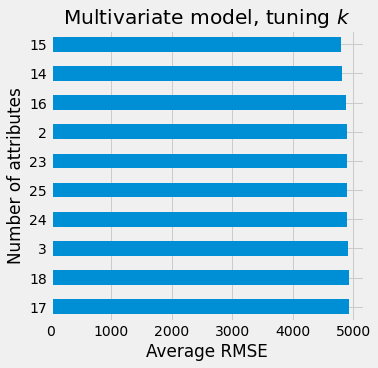

In [34]:
#print the top 10 obtained from previous hyperparameter optimization step
sorted_multivariates = multivariate_model_df.mean(axis=1).sort_values(ascending=False)
ax = sorted_multivariates[-10:].plot(kind='barh',
                                 stacked=True,
                                 figsize=(5, 5),
                                 title='Multivariate model, tuning $k$')
ax.set_xlabel('Average RMSE');
ax.set_ylabel('Number of attributes');

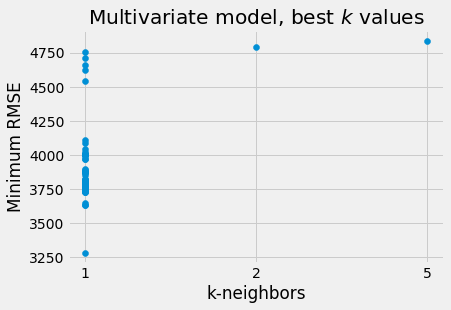

In [35]:
x = multivariate_model_df.idxmin(axis=1).sort_values().apply(lambda x: x[1])
y = multivariate_model_df.min(axis=1).sort_values()
plt.scatter(x,y)
plt.xlabel("k-neighbors")
plt.ylabel("Minimum RMSE")
plt.title("Multivariate model, best $k$ values")
plt.show()

The model with the 15th best attributes has the best average score over all $k$ values, and this time we managed to obtain better RMSEs overall, but it looks suspicious since most of the minimal values occur when $k=1$. 

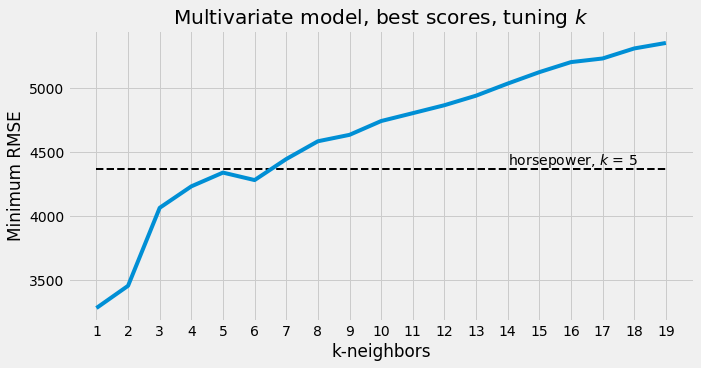

In [36]:
plt.figure(figsize=(10,5))
x=range(1,20)
line1 = int(best_attributes[0])
plt.plot(x,multivariate_model_df.min(axis=0))
plt.xticks(x)
plt.xlabel("k-neighbors")
plt.ylabel("Minimum RMSE")
plt.hlines(line1, 1, 19, linestyle='dashed',linewidth=2)
plt.text(14, 4400, "horsepower, $k$ = 5")
plt.title("Multivariate model, best scores, tuning $k$")
plt.show()

Discarding the risk of overfitting at $k <3$, we think there is maybe a good window at $3\leq k \leq6$ where the best scores are under the horsepower score dashed line, our best univariate model with default parameters. Let's find and display the set of attributes candidates. Note that we start now to store the most relevant feature sets into a Python <code>set</code> object (advantage compared to <code>list</code>, <code>tuple</code>, or <code>dictionary</code> built-in data types: *sets do not allow duplicate values*), namely <code>feature_sets</code>, for future usage.

In [37]:
#initiate feature_sets
feature_sets = set()
#add the best attribute
feature_sets.add(tuple(["horsepower"]))
#add the 2nd best attribute
feature_sets.add(tuple(["engine_size"]))
#add the full feature set
feature_sets.add(tuple(full_feature_set))
#add a feature set containing only continuous values
feature_sets.add(tuple(continuous_features))

#store best features for k-neighbors values between 3 and 6
for idx, i in enumerate(multivariate_model_df.idxmin(axis=0)[2:6]):    
    features = list(univariate_model_df.mean(axis=1).sort_values().head(i).index)
    feature_sets.add(tuple(features))
    print(f'Best feature set for n_neighbors = {idx+3}: {features}')
    print()

Best feature set for n_neighbors = 3: ['engine_size', 'horsepower']

Best feature set for n_neighbors = 4: ['engine_size', 'horsepower', 'curb_weight']

Best feature set for n_neighbors = 5: ['engine_size', 'horsepower', 'curb_weight', 'highway_mpg']

Best feature set for n_neighbors = 6: ['engine_size', 'horsepower', 'curb_weight', 'highway_mpg', 'length', 'city_mpg', 'width', 'compression_ratio', 'bore', 'wheel_base', 'num_cylinders_four', 'fuel_system_2bbl', 'peak_rpm', 'drive_wheels_rwd', 'make_mercedes-benz']



Interesting to notice, the fourth set (15 attributes) contains binary features - four cylinders, 2bbl fuel system, rear-wheel drive and Mercedes-Benz. Binary features are finally showing some predictive power.

Now, let's take an ultimate look at some of the multivariate models we've just built.

Text(0, 0.5, 'RMSE')

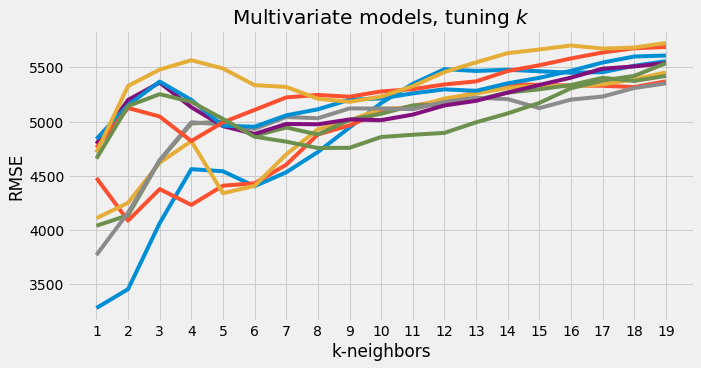

In [38]:
plt.figure(figsize=(10,5))

for idx in range(0,10):   
    plt.plot(range(1,20),multivariate_model_df.iloc[idx])
plt.title("Multivariate models, tuning $k$")
plt.xticks(range(1,20))
plt.xlabel("k-neighbors")
plt.ylabel("RMSE")

In conclusion, hierarchical feature selection and train/test validation are a bit deceptive, leading to poor results compared to the best univariate model with default parameters. Even after tuning the $k$ parameter, the small improvements noted seem to be negligible and let us a bit septic. We need  to improve the validation strategy.

## Improving the model with K-fold cross-validation
As mentioned by the [scikit-learn documentation](https://scikit-learn.org/stable/module/cross_validation.html), the cross-validation technique splits the training set into $k$ smaller sets and $k$-folds follow  the same procedure:

- a model is trained using $k-1$ of the folds as training data;

- the resulting model is validated on the remaining part of the data (*i.e.*, it is used as a test set to compute a performance measure such as accuracy).

In [39]:
from sklearn.model_selection import KFold, cross_val_score, cross_validate

In [40]:
def cross_validation(col_names, target, df, k=5, n_splits=5):
    """
    Trains a KNN model following the cross validation procedure and returns the RMSE
    
    col_name (string): the training features
    target (string): the column target
    df (DataFrame): the data
    k (int, optional): the n_neighbors parameter of KNN model we want to optimize
    n_splits (int, optional, min = 2): the number of folds
    
    output (float) : the average RMSE over n_splits
    """
    #instantiate KNeighborsRegressor class with default parameters
    knn = KNeighborsRegressor(n_neighbors = k)
    #initiate KFold, shuffle and set a seed for reproductibility
    kf = KFold(n_splits=n_splits,shuffle=True,random_state=123) 
    # Pass everything into the fit method.
    mses = cross_val_score(knn,df[col_names],df[target],
                      scoring ="neg_mean_squared_error", cv = kf)
    rmses = [np.sqrt(np.abs(mse)) for mse in mses]
    avg_rmse = np.mean(rmses)    
    return avg_rmse

In [41]:
#applying cross validation on each stored feature set and print the results
for feature_set in feature_sets:
    col_names=list(feature_set)
    score = cross_validation(col_names, target, standardized_cars, k=5, n_splits=5)
    print(f'Cross validation with {feature_set}: {score:.0f}')
    print()    

Cross validation with ('wheel_base', 'length', 'width', 'height', 'curb_weight', 'engine_size', 'bore', 'stroke', 'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg', 'highway_mpg'): 3535

Cross validation with ('symboling_B', 'symboling_C', 'symboling_D', 'symboling_E', 'symboling_F', 'symboling_G', 'make_alfa-romero', 'make_audi', 'make_bmw', 'make_chevrolet', 'make_dodge', 'make_honda', 'make_isuzu', 'make_jaguar', 'make_mazda', 'make_mercedes-benz', 'make_mercury', 'make_mitsubishi', 'make_nissan', 'make_peugot', 'make_plymouth', 'make_porsche', 'make_renault', 'make_saab', 'make_subaru', 'make_toyota', 'make_volkswagen', 'make_volvo', 'fuel_type_diesel', 'fuel_type_gas', 'aspiration_std', 'aspiration_turbo', 'doors_four', 'doors_two', 'doors_unknown', 'body_style_convertible', 'body_style_hardtop', 'body_style_hatchback', 'body_style_sedan', 'body_style_wagon', 'drive_wheels_4wd', 'drive_wheels_fwd', 'drive_wheels_rwd', 'engine_location_front', 'engine_location_rear', 'engin

The first results show pretty interesting improvements in model performance. The worst value is now under 3900!

Like in the previous section, by selecting the best features from <code>univariate_model_df</code> sorted values, 77 feature sets of increasing size go to the oven and the scores after tuning the number of folds are stored into a new DataFrame named <code>cross_validation_df</code>.

After analysis, the best sets of attributes will be added to <code>feature_sets</code>. The score obtained previously with engine size and horsepower features is now temporarily our new benchmark (RMSE = 2977).

In [42]:
#cross validation with top-𝑋 feature selection from univariate_model_df sorted values
cross_validation_df = pd.DataFrame(index=range(2,total_features))
for k in range(2,20):
    rmse=[]
    col_name="k"+str(k)
    for i in range(2,total_features):
        col_names = univariate_model_df.mean(axis=1).sort_values().head(i).index  
        rmse.append(cross_validation(col_names, target, standardized_cars, n_splits=k))
    cross_validation_df[col_name]=rmse

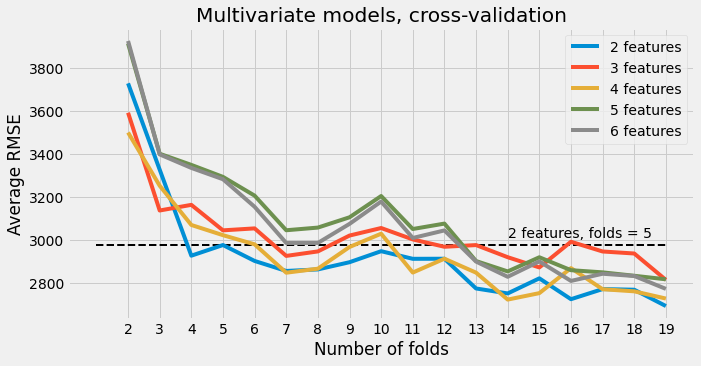

In [43]:
labels = ["2 features", "3 features", "4 features", "5 features", "6 features"]

plt.figure(figsize=(10,5))

for idx in range(0,5):   
    plt.plot(range(2,20),cross_validation_df.iloc[idx],label=labels[idx])
plt.hlines(2977, 1, 19, linestyle='dashed',linewidth=2)
plt.text(14, 3010, "2 features, folds = 5")
plt.xticks(range(2,20))
plt.title("Multivariate models, cross-validation")
plt.xlabel("Number of folds")
plt.ylabel("Average RMSE") 
plt.legend(loc="upper right")

The figure shows that the model is now starting to be much more predictive. We seat now around the 3000 levels. Since all the curves are showing the same decreasing convexity, one may be tempted to use a large number of folds since larger values visibly converge toward lower error scores. Once again, it's about finding the right balance between bias and variance. We will address this question *infra*.

In [44]:
#adding best sets to feature_sets
for idx, i in enumerate(cross_validation_df.idxmin(axis=0)):    
    features = list(univariate_model_df.mean(axis=1).sort_values().head(i).index)
    feature_sets.add(tuple(features))
    print(f'Best feature set for {idx+2} folds: {features}')
    print()
    
print('------------------------------------------')
print(f'Actual number of stored feature sets: {len(feature_sets)}')

Best feature set for 2 folds: ['engine_size', 'horsepower', 'curb_weight', 'highway_mpg', 'length', 'city_mpg', 'width', 'compression_ratio', 'bore', 'wheel_base', 'num_cylinders_four', 'fuel_system_2bbl', 'peak_rpm']

Best feature set for 3 folds: ['engine_size', 'horsepower', 'curb_weight']

Best feature set for 4 folds: ['engine_size', 'horsepower']

Best feature set for 5 folds: ['engine_size', 'horsepower']

Best feature set for 6 folds: ['engine_size', 'horsepower']

Best feature set for 7 folds: ['engine_size', 'horsepower', 'curb_weight', 'highway_mpg']

Best feature set for 8 folds: ['engine_size', 'horsepower']

Best feature set for 9 folds: ['engine_size', 'horsepower']

Best feature set for 10 folds: ['engine_size', 'horsepower']

Best feature set for 11 folds: ['engine_size', 'horsepower', 'curb_weight', 'highway_mpg']

Best feature set for 12 folds: ['engine_size', 'horsepower']

Best feature set for 13 folds: ['engine_size', 'horsepower']

Best feature set for 14 folds: 

### Forward selection & backward elimination
We introduce two additional algorithms selecting features iteratively.
- <code>forward_selection</code>: starts with an empty set and adds progressively new features following the RMSE criterion.
- <code>backward_elimination</code>: starts with a full feature set and removes at each iteration the least useful feature, whose absence improves the performance following the same RMSE criterion.


In [45]:
def forward_selection(features, target, df, min_rmse):
    """
    Trains a KNN model following the train/test validation procedure selecting features iteratively
    Starts with empty set and adds progressively new features following the RMSE criterion.
    
    features (list of string): the training features
    target (string): the column target
    df (DataFrame): the data
    min_rmse (float): the minimum RSME value we want to minimize    
    
    outputs :
        RMSE (float)
        featurees (list of string): the best feature set found by the algorithm
    """    
    all_features = df.drop(target,axis=1, inplace = False).columns
    l=len(all_features)-len(features)
    updated_features = [feature for feature in all_features if feature not in features]
    selected_features = []
    for i in range(0,l): 
        features.append(updated_features[i])        
        avg_rmse = knn_train_test(features, target, df)
        if avg_rmse < min_rmse:
            min_rmse = avg_rmse            
            selected_features.append(updated_features[i])
            features.remove(updated_features[i])
        else:
            features.remove(updated_features[i])
    if len(selected_features)>0:
        features.append(selected_features[-1])       
        forward_selection(features, target, df, min_rmse)
       
    return(knn_train_test(features, target, df), features)

def backward_elimination(features, target, df, min_rmse):
    """
    Trains a KNN model following the train/test validation procedure selecting features iteratively
    Starts with full feature set and removes at each iteration the least useful feature
     following the RMSE criterion.
     
    features (list of string): the training features
    target (string): the column target
    df (DataFrame): the data
    min_rmse (float): the minimum RSME value we want to minimize    
    
    outputs :
        RMSE (float)        
        featurees (list of string): the best feature set found by the algorithm
    """ 
    l=len(features)    
    eliminated_features = [] 
    for i in range(0,l): 
        f = [feature for feature in features if feature!=features[i]]        
        avg_rmse = knn_train_test(f, target, df)
        
        if avg_rmse < min_rmse:
            min_rmse = avg_rmse            
            eliminated_features.append(features[i])            
            
    if len(eliminated_features)>0:      
        features.remove(eliminated_features[-1])        
        backward_elimination(features, target, df, min_rmse)
    
    return(knn_train_test(features, target, df), features)  

In [46]:
#train/test validation with default parameters using forward feature selection
#store the features set obtained
min_rmse = knn_train_test(standardized_cars.columns[:-1].tolist(), "price", standardized_cars)
fs_best_rmse, fs_f = forward_selection(features=[],
                                       target="price",
                                       df=standardized_cars,
                                       min_rmse=min_rmse)
print(f'Forward Selection: {fs_f}')
print()
print(f'RMSE: {fs_best_rmse}')
#store the feature set
feature_sets.add(tuple(fs_f))

Forward Selection: ['horsepower', 'highway_mpg', 'make_mercedes-benz', 'drive_wheels_rwd', 'make_peugot', 'make_volkswagen', 'make_audi', 'make_porsche', 'city_mpg', 'make_alfa-romero', 'engine_type_rotor', 'fuel_system_2bbl', 'make_saab', 'make_isuzu', 'make_chevrolet']

RMSE: 2815.095801475529


In [47]:
#train/test validation with default parameters using backward elimination
#store the feature set obtained
features = standardized_cars.columns[:-1].tolist()
min_rmse = knn_train_test(features, "price", standardized_cars)
#min_rmse = standardized_cars["price"].max()
#print(min_rmse)
be_best_rmse, be_f = backward_elimination(features=features,
                                          target="price",
                                          df=standardized_cars,
                                          min_rmse=min_rmse)
print(f'Backward Elimination: {be_f}')
print()
print(f'RMSE: {be_best_rmse}')
#store the feature set
feature_sets.add(tuple(be_f))

Backward Elimination: ['symboling_B', 'symboling_C', 'symboling_F', 'make_alfa-romero', 'make_audi', 'make_honda', 'make_isuzu', 'make_mazda', 'make_mercury', 'make_nissan', 'make_renault', 'make_saab', 'make_toyota', 'make_volkswagen', 'doors_two', 'body_style_convertible', 'body_style_hatchback', 'body_style_sedan', 'drive_wheels_4wd', 'drive_wheels_fwd', 'drive_wheels_rwd', 'engine_location_front', 'engine_location_rear', 'engine_type_dohc', 'engine_type_l', 'engine_type_rotor', 'num_cylinders_five', 'num_cylinders_four', 'num_cylinders_three', 'num_cylinders_two', 'fuel_system_1bbl', 'fuel_system_4bbl', 'fuel_system_mpfi', 'fuel_system_spdi', 'fuel_system_spfi', 'length', 'height', 'curb_weight', 'engine_size', 'bore', 'stroke', 'horsepower', 'highway_mpg']

RMSE: 2348.328023370358


Composed of 43 attributes, the feature set obtained by backward elimination is doing the best RMSE score we made until now. This is very promising, showing that feature selection is a very important step in machine learning.

Let's now build another DataFrame tuning the number of folds into <code>cross_validation</code> function and using each set of attributes stored in <code>feature_sets</code> as parameter.

Then, we will use this DataFrame to find the optimal number of folds for each series of RMSEs values and plot the best result in MAPE/RMSE terms after writing a new cross-validation function.

In [48]:
#construct a dataframe with the scores of the stored feature sets
final_df = pd.DataFrame()
#keep into memory the features names
features_list = list(feature_sets)
for k in range(2,20):
    rmse=[]
    col_name="k"+str(k)
    for feature_set in features_list:
        features = list(feature_set)
        score = cross_validation(features, target, standardized_cars, k=5, n_splits=k)
        rmse.append(score)    
    final_df[col_name]=rmse

Text(0, 0.5, 'Average RMSE')

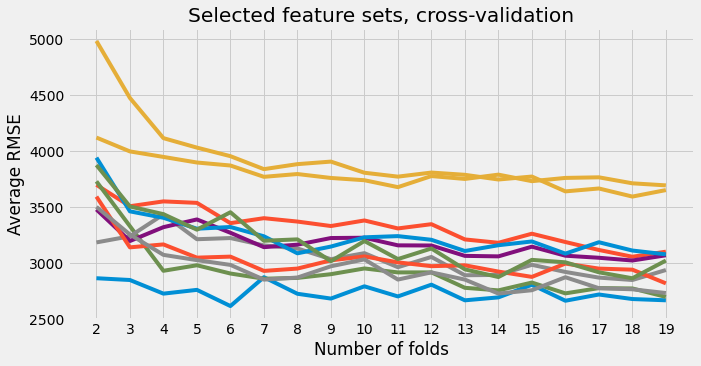

In [49]:
plt.figure(figsize=(10,5))
for idx in range(0,len(feature_sets)):
    plt.plot(range(2,20),final_df.iloc[idx,:])
plt.title("Selected feature sets, cross-validation")
plt.xlabel("Number of folds")
plt.xticks(range(2,20))
plt.ylabel("Average RMSE")
#plt.legend(loc="upper right")

The chart above shows clearly there is a substantial *gap* between two series and the others ones regardless the cross-validation strategy. The full feature set is one of them. Enough to say that feature selection is not optional here!

Note that the second worst series is the best univariate model (horsepower), showing now its intrinsic limits.

In [50]:
#display the 2 worst scores series
for idx in final_df.idxmax().unique():
    feature_set  = features_list[idx]
    print(f'Number of features: {len(feature_set)}')
    print(feature_set)
    print()

Number of features: 79
('symboling_B', 'symboling_C', 'symboling_D', 'symboling_E', 'symboling_F', 'symboling_G', 'make_alfa-romero', 'make_audi', 'make_bmw', 'make_chevrolet', 'make_dodge', 'make_honda', 'make_isuzu', 'make_jaguar', 'make_mazda', 'make_mercedes-benz', 'make_mercury', 'make_mitsubishi', 'make_nissan', 'make_peugot', 'make_plymouth', 'make_porsche', 'make_renault', 'make_saab', 'make_subaru', 'make_toyota', 'make_volkswagen', 'make_volvo', 'fuel_type_diesel', 'fuel_type_gas', 'aspiration_std', 'aspiration_turbo', 'doors_four', 'doors_two', 'doors_unknown', 'body_style_convertible', 'body_style_hardtop', 'body_style_hatchback', 'body_style_sedan', 'body_style_wagon', 'drive_wheels_4wd', 'drive_wheels_fwd', 'drive_wheels_rwd', 'engine_location_front', 'engine_location_rear', 'engine_type_dohc', 'engine_type_l', 'engine_type_ohc', 'engine_type_ohcf', 'engine_type_ohcv', 'engine_type_rotor', 'num_cylinders_eight', 'num_cylinders_five', 'num_cylinders_four', 'num_cylinders_s

### Elbow detection point
It's possible to find the point of maximum curvature (elbow point) in a system with the [Kneedle algorithm](https://www1.icsi.berkeley.edu/~barath/papers/kneedle-simplex11.pdf). A Python package, [kneed](https://github.com/arvkevi/kneed), has been created by Kevin Arvai. For more information about parameters and how it works, see this [Kaggle notebook](https://www.kaggle.com/kevinarvai/knee-elbow-point-detection).
Applied to the RMSE curves, the elbow point will be equal to the appropriate number of folds after which information gain becomes negligible. Indeed, a large(r) number of folds will increase the variance of the estimate, and that's not desirable. As pointed by [Sebastian Raschka](https://sebastianraschka.com/faq/docs/number-of-kfolds.html):
> The reason for the increasing variance of the estimate is that the overlap between training sets increases with an increasing size of [folds].

Example of elbow point detection with the first feature set stored in <code>final_df</code>:

In [51]:
from kneed import KneeLocator

Feature set: ('symboling_B', 'symboling_C', 'symboling_F', 'make_alfa-romero', 'make_audi', 'make_honda', 'make_isuzu', 'make_mazda', 'make_mercury', 'make_nissan', 'make_renault', 'make_saab', 'make_toyota', 'make_volkswagen', 'doors_two', 'body_style_convertible', 'body_style_hatchback', 'body_style_sedan', 'drive_wheels_4wd', 'drive_wheels_fwd', 'drive_wheels_rwd', 'engine_location_front', 'engine_location_rear', 'engine_type_dohc', 'engine_type_l', 'engine_type_rotor', 'num_cylinders_five', 'num_cylinders_four', 'num_cylinders_three', 'num_cylinders_two', 'fuel_system_1bbl', 'fuel_system_4bbl', 'fuel_system_mpfi', 'fuel_system_spdi', 'fuel_system_spfi', 'length', 'height', 'curb_weight', 'engine_size', 'bore', 'stroke', 'horsepower', 'highway_mpg')

Elbow point: 5


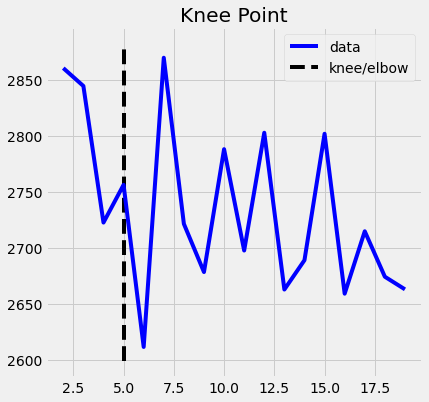

In [52]:
kl = KneeLocator(
    range(2,20),
    final_df.iloc[0,:],
    curve="convex",
    direction="decreasing",
    S=0.0,
    interp_method="polynomial"
)
kl.plot_knee()

print(f'Feature set: {features_list[0]}')
print()
print(f'Elbow point: {kl.elbow}')

Here, the first significant elbow point, or the first point of maximum curvature from a polynomial interpolation point of view, is marked by the dashed line. The error is still decreasing after the elbow point, but at the cost of an increasing variance that can lead to worst performances when the model will be applied to a new dataset. 

Now, we will write a new cross-validation function, <code>cross_validation_predictions</code>, that uses <code>cross_val_predict</code> scikit-learn function instead of <code>cross_val_score</code>. We will use the predictions output to calculate the MAPE score in conjunction with the RMSE. Remember that we want *in the last instance* to compare our results with Kibler *et al.* (1989).

To end this study, the last charts below show the best feature sets found minimizing respectively the MAPE criterion and the RMSE criterion.

In [53]:
from sklearn.model_selection import cross_val_predict

In [54]:
def cross_validation_predictions(col_names, target, df, k = 5, n_splits = 5):
    """
    Trains a KNN model following the cross validation procedure
    and returns the predictions & testing set
    
    col_names (string): the training features
    target (string): the column target
    df (DataFrame): the data
    k (int): the n_neighbors parameter of KNN model we want to optimize
    n_splits (int, min = 2): the number of folds    
    
    output:      
      predictions (array): model predictions
    
    """
    knn = KNeighborsRegressor(n_neighbors = k)
    #initiate KFold, shuffle and set a seed for reproductibility 
    kf = KFold(n_splits=n_splits,shuffle=True,random_state=123) 
    predictions = cross_val_predict(knn,df[col_names],df[target],cv = kf)
    return predictions

def plot_pred(target, predictions, title=""):
    """
    Scatter plot of model predictions (y-axis) vs target (x-axis)
    
    target (1d array): the true values of the attribute we want to predict
    predictions (1d array): the predictions made by the model   
    title (string, optional): the title of the chart
    
    """
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    mape = mean_absolute_percentage_error(target, predictions)
    rmse = mean_squared_error(target, predictions) ** (1/2)
    string_mape = f'MAPE on dataset: {mape:.2%}'
    string_rmse = f'RMSE on dataset: {rmse:.0f}'
    ax.scatter(target, predictions)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes,ls="--", c="red")
    plt.text(30000, 10100,  string_mape)
    plt.text(30000, 11500,  string_rmse)
    plt.title(title)
    plt.ylabel('Model predictions')
    plt.xlabel('Truths')
    plt.xlim(5000,46000)
    plt.ylim(5000,46000)
    plt.show()

def elbow(x, y, curve="convex", direction="decreasing", s = 0.0, interp_method='polynomial'):
    """
    Calculate the elbow point of a curve.
    Optional parameters: see https://www.kaggle.com/kevinarvai/knee-elbow-point-detection
    
    x (1d array): the x-coordinates of the curve we want to calculate the elbow point
    y (1d array): the y-coordinates of the curve we want to calculate the elbow point  
    
    output: the elbow point (int)
    
    """  
       
    kl = KneeLocator(
        x,
        y,
        curve=curve,
        direction=direction,
        S=s,
        interp_method=interp_method
    )
    
    return kl.elbow

Folds: 6
Feature set: ['engine_size', 'horsepower', 'curb_weight', 'highway_mpg']


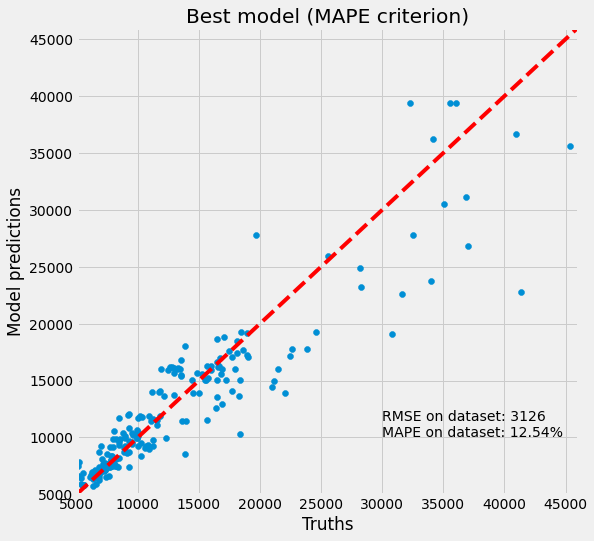

------------------------------------------------------------------

Folds: 5
Feature set: ['symboling_B', 'symboling_C', 'symboling_F', 'make_alfa-romero', 'make_audi', 'make_honda', 'make_isuzu', 'make_mazda', 'make_mercury', 'make_nissan', 'make_renault', 'make_saab', 'make_toyota', 'make_volkswagen', 'doors_two', 'body_style_convertible', 'body_style_hatchback', 'body_style_sedan', 'drive_wheels_4wd', 'drive_wheels_fwd', 'drive_wheels_rwd', 'engine_location_front', 'engine_location_rear', 'engine_type_dohc', 'engine_type_l', 'engine_type_rotor', 'num_cylinders_five', 'num_cylinders_four', 'num_cylinders_three', 'num_cylinders_two', 'fuel_system_1bbl', 'fuel_system_4bbl', 'fuel_system_mpfi', 'fuel_system_spdi', 'fuel_system_spfi', 'length', 'height', 'curb_weight', 'engine_size', 'bore', 'stroke', 'horsepower', 'highway_mpg']


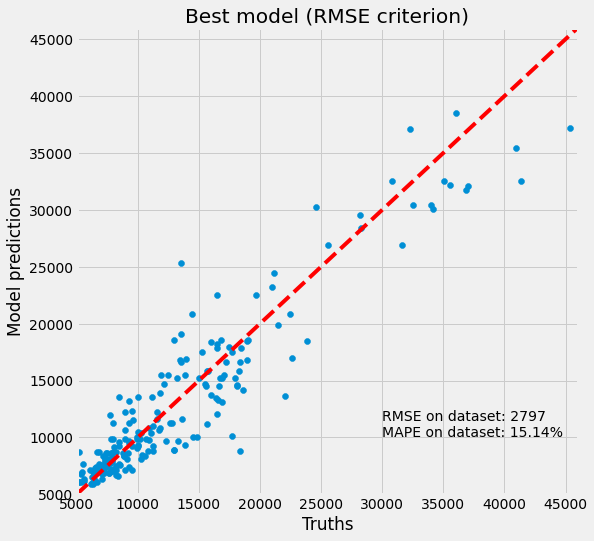

In [55]:
elbows=[]

mape = np.zeros(shape=(len(feature_sets),))
rmse = np.zeros(shape=(len(feature_sets),))
predictions_df = pd.DataFrame()
for idx in range(0,len(feature_sets)):
    elbows.append(elbow(range(2,20),final_df.iloc[idx,:]))
for idx in range(0,len(feature_sets)):
    col_name="feature_sets"+str(idx)    
    pred = cross_validation_predictions(list(features_list[idx]),
                                        "price",
                                        standardized_cars,
                                        k = 5,
                                        n_splits = elbows[idx])
    mape[idx]+=mean_absolute_percentage_error(standardized_cars["price"], pred)
    rmse[idx]+=mean_squared_error(standardized_cars["price"], pred) ** (1/2)
    predictions_df[col_name] = pred

for i in range(0,2):
    if i == 0:        
        idx_min = np.argmin(mape) #first chart = best MAPE
        title = "Best model (MAPE criterion)"
    else:
        idx_min = np.argmin(rmse) #2nd chart = best RMSE
        title = "Best model (RMSE criterion)"
    print(f'Folds: {elbows[idx_min]}')
    print(f'Feature set: {list(features_list[idx_min])}') 
    plot_pred(standardized_cars["price"], predictions_df.iloc[:,idx_min], title)
    if i == 0:
        print('------------------------------------------------------------------') 
        print() 


## Final Results
After a long process, we obtained finally an error score very closed to Kibler *et al.* (1989) best past result (IBL algorithm, 11,84%).

It's interesting to note that when minimizing the MAPE score, the best result is obtained with continuous features only (engine size, horsepower, curb weight, highway mpg), found using *univariate feature selection*.

But when minimizing the RMSE, the binary features are playing a more important role (in particular, the *make* of the car), and this time this is the *backward elimination* technique that worked better for us. 

An interesting fact we have discovered during the process: [MAPE and RMSE scores don't have clear linear relationship](https://community.dataquest.io/t/linear-relationship-between-rmse-and-mean-absolute-percentage-error/548378/4). In other words, scoring parameter is a non trivial task, and the choice of the scoring function we want to optimize need to be thought carefully since the very start of the project.

Also, since the target (car prices) is skewed to the right, the biggest prices are "high variance", being the most challenging values to predict. It would be interesting, for further investigations, to model *the logarithm of the price* rather than the price in monetary unit.

Some changes could improve the model. Between several ideas:
- at the first stage of data preprocessing, narrow the data removing all rows with missing values. That's what Kibler *et al.* (1989) did, working with a final dataset of only 159 observations;
- if we don't want to narrow the data such drastically, it's also possible to try other [imputation of missing values techniques](https://scikit-learn.org/stable/modules/impute.html);
- use cross-validation elbow point to find then the optimal number of neighbors for each feature set.

In [56]:
from IPython.core.display import HTML

def css_styling():
    styles = open("css/custom.css", "r").read() #or edit path to custom.css
    return HTML(styles)
css_styling()